# 0. Importing necessary libraries and data

In [17]:
import numpy as np # Library for calculation
import matplotlib.pyplot as plt # Library for plotting
import pandas as pd
import os # Library for handle file, folder
import sys

from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve

In [18]:
df = pd.read_csv("./ObesityDataset.csv")

X, y = df.drop('NObeyesdad', axis=1), df['NObeyesdad']

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (2111, 14)
Target shape: (2111,)


# 1. Preprocessing

In [19]:
# identify numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

numeric = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric, numerical_features),
        ("cat", categorical, categorical_features),
    ],
    remainder="drop"
)

# merge into a X, y value
X = preprocess.fit_transform(X)
y = y.values

print("Preprocessed features shape:", X.shape)
print("Target shape:", y.shape)

Preprocessed features shape: (2111, 29)
Target shape: (2111,)


# 2. Train/Test Split

We split the preprocessed data into 60% training, 20% validation, 20% testing

In [31]:
# split the preprocessed data
X_train_all, X_test, y_train_all, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.2, random_state=42, stratify=y_train_all
)

# 3. Training and Validation Phase

We need to finetune the hyperparameter to choose the highest accuracy list of hyperparameters. We fine tune:
- Number of decision trees: [100, 200, 300]
- Max depth: [None, 10, 20]
- Minimum number of samples that must be present in a node for it to be considered a leaf node: [1, 5, 10]


In [24]:
n_estimators_list = [100, 200, 300]
max_depth_list = [None, 10, 20]
min_samples_leaf_list = [1, 5, 10]

best_score = -1
best_params = None

for n in n_estimators_list:
    for d in max_depth_list:
        for leaf in min_samples_leaf_list:
            
            model = RandomForestClassifier(
                n_estimators=n,
                max_depth=d,
                min_samples_leaf=leaf,
                random_state=42,
                n_jobs=-1,
                class_weight="balanced"
            )
            
            model.fit(X_train, y_train)
            
            y_val_pred = model.predict(X_val)
            val_acc = accuracy_score(y_val, y_val_pred)
            
            print(f"n={n}, depth={d}, leaf={leaf}, val_acc={val_acc:.4f}")
            
            if val_acc > best_score:
                best_score = val_acc
                best_params = (n, d, leaf)

n=100, depth=None, leaf=1, val_acc=0.8462
n=100, depth=None, leaf=5, val_acc=0.7870
n=100, depth=None, leaf=10, val_acc=0.7337
n=100, depth=10, leaf=1, val_acc=0.8166
n=100, depth=10, leaf=5, val_acc=0.7722
n=100, depth=10, leaf=10, val_acc=0.7249
n=100, depth=20, leaf=1, val_acc=0.8432
n=100, depth=20, leaf=5, val_acc=0.7870
n=100, depth=20, leaf=10, val_acc=0.7337
n=200, depth=None, leaf=1, val_acc=0.8521
n=200, depth=None, leaf=5, val_acc=0.7959
n=200, depth=None, leaf=10, val_acc=0.7308
n=200, depth=10, leaf=1, val_acc=0.8254
n=200, depth=10, leaf=5, val_acc=0.7692
n=200, depth=10, leaf=10, val_acc=0.7249
n=200, depth=20, leaf=1, val_acc=0.8521
n=200, depth=20, leaf=5, val_acc=0.7959
n=200, depth=20, leaf=10, val_acc=0.7308
n=300, depth=None, leaf=1, val_acc=0.8521
n=300, depth=None, leaf=5, val_acc=0.7840
n=300, depth=None, leaf=10, val_acc=0.7426
n=300, depth=10, leaf=1, val_acc=0.8195
n=300, depth=10, leaf=5, val_acc=0.7722
n=300, depth=10, leaf=10, val_acc=0.7308
n=300, depth=2

In [32]:
n, d, leaf = best_params

model_RF = RandomForestClassifier(
    n_estimators=n,
    max_depth=d,
    min_samples_leaf=leaf,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

model_RF.fit(X_train, y_train)

y_pred = model_RF.predict(X_test)

acc = accuracy_score(y_test, y_pred)
rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
prec = rep["macro avg"]["precision"]
rec = rep["macro avg"]["recall"]
f1 = rep["macro avg"]["f1-score"]
cm = confusion_matrix(y_test, y_pred)

print("Acc:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1:", f1)

Acc: 0.8605200945626478
Precision: 0.867688885826098
Recall: 0.8577391227637533
F1: 0.8603850452944524


In [35]:
def plot_confusion_matrix(y_true, y_pred, labels=[0,1], normalize=False, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred).astype(float)
    
    if normalize:
        cm_sum = cm.sum(axis=1, keepdims=True)
        cm = cm / cm_sum
        fmt = ".2f"
    else:
        cm = cm.astype(int) 
        fmt = "d"
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    threshold = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > threshold else "black")
    plt.show()

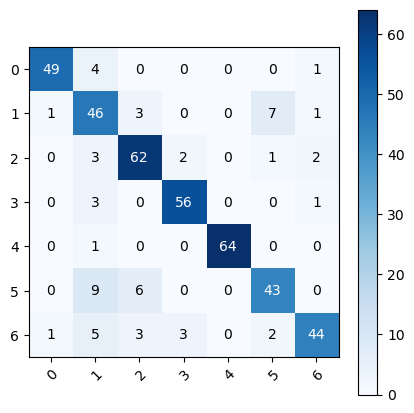

In [36]:
plot_confusion_matrix(y_test, y_pred, normalize=False, title="Confusion Matrix")